In [84]:
from IPython.core.display import display,HTML
display(HTML("<style>.container {width: 99% !important;}</style>"))

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import pygazeanalyser
import matplotlib
from matplotlib import pyplot as plt
from pygazeanalyser.edfreader import read_edf
from pygazeanalyser import gazeplotter
from scipy import stats, signal, ndimage
import re
import os
import mne
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.set_printoptions(suppress = True)

In [3]:
# set relevant directories and paths
#workingfolder = '/Users/user/Desktop/Experiments/Nick/AttentionSaccade/' #laptop directory
workingfolder = '/home/sammirc/Experiments/Nick/AttentionSaccade' #workstation directory
eyedat        = os.path.join(workingfolder, 'eyes')
behdat        = os.path.join(workingfolder, 'behaviour/csv')
eegdat        = os.path.join(workingfolder, 'EEG') #only on workstation though, no eeg data on laptop
eyelist       = os.listdir(eyedat)
eyelist       = np.sort(eyelist)
behlist       = np.sort(os.listdir(behdat))
saccadedat    = os.path.join(workingfolder, 'saccades')
if not os.path.exists(saccadedat):
    os.mkdir(saccadedat)
sublist = [1,2,3,4, 5, 6, 7, 8, 9]
sublist = [1,2,  4, 5, 6, 7, 8, 9] #subject 3 has 961 trials in eyetracker data, and 960 in behavioural - check with nick. for now, remove from analysis
parts   = ['a','b']

epsubs   = [3, 4, 5, 6,9]
ohbasubs = [1, 2, 7 ,8]
hrefsubs = [7, 8]

#1KHz  sample: 1 5 6 7 8 9
#250Hz sample: 4

In [4]:
# specs for the task
resxy = (1920,1080)
scrsize = (60,34)
scrdist = 100 # cm
#pixpcm = np.mean([resxy[0]/scrsize[0],resxy[1]/scrsize[1]])
#samplerate = 1000.0 # Hz , sample every 1ms. subject 4 has 250Hz SR, all other 1kHz
samplerate = 250.0 #for subject 4
# Data files
sep = '\t' #value separator
EDFSTART = "_BEG"
EDFSTOP  = "END"
TRIALORDER = ["B(.*)_T(.*)_BEG","B(.*)_T(.*)_CUE","B(.*)_T(.*)_ARR","B(.*)_T(.*)_RESP","B(.*)_T(.*)_END"]
INVALCODE = np.NaN

In [5]:
# columns in the behavioural data
# subject  - subject number
# session  - session number
# task     - task type (1 = attention, 2 = saccade)
# cuecol   - 
# cueloc   - cued location (1:8)
# validity - validity of cue (1 = valid, 0 = invalid)
# targloc  - location of target (1:8) - can be same or different to cueloc depending on validity of trial
# targtilt - orientation of target (1 = , 2 = )
# delay    -
# resp     - response made: 0 = no response, 1 = , 2 = 
# time     - NaN on saccade trials (or trials with no response), otherwise RT in seconds
# corr     - accuracy of trial (1 = correct, 0 = incorrect), all saccade trials coded with 0 as no response

In [5]:
edat = []
for sub in range(len(sublist)):
    print('working on S%02d'%(sublist[sub]))
    
    if sub in range(0,2):
        fname    = os.path.join(eyedat, 'AttSacc_S%02d.asc'%(sublist[sub]));              datname  = os.path.join(behdat, 'AttSacc_S%02d.csv'%(sublist[sub]))
        bdata    = pd.DataFrame.from_csv(datname, header=0, sep = ',', index_col=False);  edata    = read_edf(fname, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)
    elif sub in range(2,9):
        fname    = os.path.join(eyedat, 'AttSacc_S%02d%s.asc'%(sublist[sub], parts[0]));  datname  = os.path.join(behdat, 'AttSacc_S%02d%s.csv'%(sublist[sub], parts[0]))
        bdata    = pd.DataFrame.from_csv(datname, header=0, sep = ',', index_col=False);  edata    = read_edf(fname, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)
        
        fname2   = os.path.join(eyedat, 'AttSacc_S%02d%s.asc'%(sublist[sub], parts[1]));  datname2 = os.path.join(behdat, 'AttSacc_S%02d%s.csv'%(sublist[sub], parts[1]))
        bdata2   = pd.DataFrame.from_csv(datname2, header=0, sep = ',', index_col=False); edata2   = read_edf(fname2, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)
        
    if sublist[sub] in epsubs: #EP locations
        targlocations = np.array([[288,119], # cueloc = 1
                                 [119, 288], # cueloc = 2
                                 [-119, 288],# cueloc = 3
                                 [-288, 119],# cueloc = 4
                                 [-288,-119],# cueloc = 5
                                 [-119,-288],# cueloc = 6
                                 [119,-288], # cueloc = 7
                                 [288,-119]] # cueloc = 8
                                 )
    elif sublist[sub] in ohbasubs: #ohba locations
        targlocations = np.array([[399,165], # cueloc = 1
                                 [165, 399], # cueloc = 2
                                 [-165, 399],# cueloc = 3
                                 [-399, 165],# cueloc = 4
                                 [-399,-165],# cueloc = 5
                                 [-165,-399],# cueloc = 6
                                 [165,-399], # cueloc = 7
                                 [399,-165]] # cueloc = 8
                                 )
                                 
    targlocations[:,0] = targlocations[:,0]+(resxy[0]/2) # correct x from tracker coords to normal coords
    targlocations[:,1] = targlocations[:,1]+(resxy[1]/2) # correct y from tracker coords to normal coords

    if sub in range(0,2): #subjects 1 and 2 only have one file, not two so script changes accordingly.
        print('combining S%02d eyetracking and behavioural data, and adding triggers to eyetracking data'%(sublist[sub]))
        for trial in range(len(edata)):
            trl = bdata.iloc[trial,:]
            edata[trial]['behaviour'] = {
                'subject'    : trl.loc['subject'] , 'session'  : trl.loc['session'] ,
                'task'       : trl.loc['task']    , 'cuecol'   : trl.loc['cuecol']  ,
                'cueloc'     : trl.loc['cueloc']  , 'validity' : trl.loc['validity'],
                'targloc'    : trl.loc['targloc'] , 'targtilt' : trl.loc['targtilt'],
                'delay'      : trl.loc['delay']   , 'resp'     : trl.loc['resp']    ,
                'time'       : trl.loc['time']    , 'corr'     : trl.loc['corr']    , 
                'targlocpix' : targlocations[int(trl.loc['targloc'])-1]
            }
            trigs = edata[trial]['events']['msg']
            if len(trigs) == 4: # attention trial
                trltype = 1 #attention trial
                begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
                resptrig  = edata[trial]['events']['msg'][3][0] #get edf timestamp for array trigger
            elif len(trigs) == 3: #saccade trial, no response
                trltype = 2 #saccade trial
                begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
                #find sample nearest to the trigger time
            begind  = np.argmin(np.abs(begtrig  - edata[trial]['trackertime']))
            cueind  = np.argmin(np.abs(cuetrig  - edata[trial]['trackertime']))
            arrind  = np.argmin(np.abs(arrtrig  - edata[trial]['trackertime']))
            if trltype == 1:
                respind = np.argmin(np.abs(resptrig - edata[trial]['trackertime']))
            if trltype == 1: #attention trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],
                    "resp"  : [resptrig, respind]}
            if trltype == 2: #saccade trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],}
            edata[trial]['triggers'] = triggers
            # triggers : [EDFTIME, TRIAL_TIME]      
        saccfname = '%s/AttentionSaccade_S%02d_SaccadeData.csv' %(saccadedat, sublist[sub])
        if not os.path.exists(saccfname):    
            print('writing saccade data to file now')
            saccfile     = open(saccfname, 'w')
            saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                'subject','trial','start','end','duration','startx', 'starty','endx', 'endy', 'velocity'))
            for trial in range(len(edata)):
                saccades = edata[trial]['events']['Esac']
                tnum = trial + 1
                subject = edata[trial]['behaviour']['subject']
                ttime = edata[trial]['trackertime'][0]
                #saccades[saccade]: start, end, duration, startx, starty, endx, endy
                for saccade in range(len(saccades)):
                    saccadevel = np.sqrt((saccades[saccade][5]-saccades[saccade][3])**2 +
                                         (saccades[saccade][6]-saccades[saccade][4])**2  ) / saccades[saccade][2]
                    saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                            subject,tnum,saccades[saccade][0]-ttime,saccades[saccade][1]-ttime,
                            saccades[saccade][2],saccades[saccade][3],saccades[saccade][4],
                            saccades[saccade][5],saccades[saccade][6],saccadevel))
            saccfile.close()
        comb = edata
        
    elif sub not in range(0,2): # subjects 3 onwards have two files, not one
        print('combining S%02d part 1 eyetracking and behavioural data, and adding triggers to eyetracking data'%(sublist[sub]))
        for trial in range(len(edata)):
            trl  = bdata.iloc[trial,:]
            edata[trial]['behaviour'] = {
                'subject'    : trl.loc['subject'] , 'session'  : trl.loc['session'] ,
                'task'       : trl.loc['task']    , 'cuecol'   : trl.loc['cuecol']  ,
                'cueloc'     : trl.loc['cueloc']  , 'validity' : trl.loc['validity'],
                'targloc'    : trl.loc['targloc'] , 'targtilt' : trl.loc['targtilt'],
                'delay'      : trl.loc['delay']   , 'resp'     : trl.loc['resp']    ,
                'time'       : trl.loc['time']    , 'corr'     : trl.loc['corr']    , 
                'targlocpix' : targlocations[int(trl.loc['targloc'])-1]
                }
            trigs = edata[trial]['events']['msg']
            if len(trigs) == 4: # attention trial
                trltype = 1 #attention trial
                begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
                resptrig  = edata[trial]['events']['msg'][3][0] #get edf timestamp for array trigger
            elif len(trigs) == 3: #saccade trial, no response
                trltype = 2 #saccade trial
                begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
            #find sample nearest to the trigger time
            begind  = np.argmin(np.abs(begtrig  - edata[trial]['trackertime']))
            cueind  = np.argmin(np.abs(cuetrig  - edata[trial]['trackertime']))
            arrind  = np.argmin(np.abs(arrtrig  - edata[trial]['trackertime']))
            if trltype == 1:
                respind = np.argmin(np.abs(resptrig - edata[trial]['trackertime']))
            if trltype == 1: #attention trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],
                    "resp"  : [resptrig, respind]}
            if trltype == 2: #saccade trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],}
            edata[trial]['triggers'] = triggers
            # triggers : [EDFTIME, TRIAL_TIME]      
        saccfname = '%s/AttentionSaccade_S%02d%s_SaccadeData.csv' %(saccadedat, sublist[sub],parts[0])
        if not os.path.exists(saccfname):    
            print('writing saccade data to file now')
            saccfile     = open(saccfname, 'w')
            saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                'subject','trial','start','end','duration','startx', 'starty','endx', 'endy', 'velocity'))
            for trial in range(len(edata)):
                saccades = edata[trial]['events']['Esac']
                tnum = trial + 1
                subject = edata[trial]['behaviour']['subject']
                ttime = edata[trial]['trackertime'][0]
                #saccades[saccade]: start, end, duration, startx, starty, endx, endy
                for saccade in range(len(saccades)):
                    saccadevel = np.sqrt((saccades[saccade][5]-saccades[saccade][3])**2 +
                                         (saccades[saccade][6]-saccades[saccade][4])**2  ) / saccades[saccade][2]
                    saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                            subject,tnum,saccades[saccade][0]-ttime,saccades[saccade][1]-ttime,
                            saccades[saccade][2],saccades[saccade][3],saccades[saccade][4],
                            saccades[saccade][5],saccades[saccade][6],saccadevel))
            saccfile.close()
        print('combining S%02d part 2 eyetracking and behavioural data, and adding triggers to eyetracking data'%(sublist[sub]))
        for trial in range(len(edata2)):
            trl          = bdata2.iloc[trial,:]
            edata2[trial]['behaviour'] = {
                'subject'    : trl.loc['subject'] , 'session'  : trl.loc['session'] ,
                'task'       : trl.loc['task']    , 'cuecol'   : trl.loc['cuecol']  ,
                'cueloc'     : trl.loc['cueloc']  , 'validity' : trl.loc['validity'],
                'targloc'    : trl.loc['targloc'] , 'targtilt' : trl.loc['targtilt'],
                'delay'      : trl.loc['delay']   , 'resp'     : trl.loc['resp']    ,
                'time'       : trl.loc['time']    , 'corr'     : trl.loc['corr']    ,
                'targlocpix' : targlocations[int(trl.loc['targloc'])-1]
            }
            trigs = edata2[trial]['events']['msg']
            if len(trigs) == 4: # attention trial
                trltype = 1 #attention trial
                begtrig   = edata2[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata2[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata2[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
                resptrig  = edata2[trial]['events']['msg'][3][0] #get edf timestamp for array trigger
            elif len(trigs) == 3: #saccade trial, no response
                trltype = 2 #saccade trial
                begtrig   = edata2[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata2[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata2[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
            #find sample nearest to the trigger time
            begind  = np.argmin(np.abs(begtrig  - edata2[trial]['trackertime']))
            cueind  = np.argmin(np.abs(cuetrig  - edata2[trial]['trackertime']))
            arrind  = np.argmin(np.abs(arrtrig  - edata2[trial]['trackertime']))
            if trltype == 1:
                respind = np.argmin(np.abs(resptrig - edata2[trial]['trackertime']))
            if trltype == 1: #attention trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],
                    "resp"  : [resptrig, respind]}
            if trltype == 2: #saccade trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],}
            edata2[trial]['triggers'] = triggers
            # triggers : [EDFTIME, TRIAL_TIME]  
        saccfname2    = '%s/AttentionSaccade_S%02d%s_SaccadeData.csv' %(saccadedat, sublist[sub],parts[1])
        if not os.path.exists(saccfname2):
            print('writing saccade data to file now')
            saccfile2     = open(saccfname2, 'w')
            saccfile2.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                'subject','trial','start','end','duration','startx', 'starty','endx', 'endy', 'velocity'))
            for trial in range(len(edata2)):
                saccades = edata2[trial]['events']['Esac']
                tnum = trial + 1
                subject = edata2[trial]['behaviour']['subject']
                ttime = edata2[trial]['trackertime'][0]
                #saccades[saccade]: start, end, duration, startx, starty, endx, endy
                for saccade in range(len(saccades)):
                    saccadevel = np.sqrt((saccades[saccade][5]-saccades[saccade][3])**2 +
                                         (saccades[saccade][6]-saccades[saccade][4])**2  ) / saccades[saccade][2]
                    saccfile2.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                            subject,tnum,saccades[saccade][0]-ttime,saccades[saccade][1]-ttime,
                            saccades[saccade][2],saccades[saccade][3],saccades[saccade][4],
                            saccades[saccade][5],saccades[saccade][6],saccadevel))
            saccfile2.close()
        comb = edata + edata2
    edat.append(comb)

working on S01
combining S01 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S02
combining S02 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S04
combining S04 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S04 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S05
combining S05 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S05 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S06
combining S06 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S06 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S07
combining S07 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S07 part 2 eyetracking and behavioural data, and adding tri

In [7]:
# go through every subject and trial to calculate saccadic response time for a given trial
# finds the first saccade of a trial after the target appears ('array' trigger)
# takes the time at which is starts, and subtracts the time at which the array appears, to calculate
# saccade response time
# saccades: start, end, duration, startx, starty, endx, endy

for isub in range(len(edat)):
    sacctask = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task'] == 2.0]
    for i in sacctask:
        targettrig   = edat[isub][i]['triggers']['array']
        fstime       = edat[isub][i]['trackertime'][0]
        if len(edat[isub][i]['events']['Esac']) > 0:
            trlsaccades  = np.array(edat[isub][i]['events']['Esac']) #extract saccades for trial
            trlsaccades  = trlsaccades[np.argsort(trlsaccades[:,0])] #sort saccades by start time
            inds         = np.squeeze(np.where(trlsaccades[:,0] >= targettrig[0])) # find saccades after probe
            if inds.size > 1:
                firstind = inds[0] #take first saccade after probe
                firstsaccade = trlsaccades[firstind]
                edat[isub][i]['behaviour']['fstime']       = fstime #add first sample time to behavioural data
                edat[isub][i]['behaviour']['firstsaccade'] = firstsaccade #add all saccade data
                edat[isub][i]['behaviour']['saccadetime']  = firstsaccade[0]-fstime - targettrig[1] #add just saccadic response time
            elif inds.size == 1: #only one saccade happened after the probe, so firstind = inds
                firstind = inds # firstind = 0, as only 1 saccade in trial
                firstsaccade = trlsaccades[firstind]
                edat[isub][i]['behaviour']['fstime']       = fstime
                edat[isub][i]['behaviour']['firstsaccade'] = firstsaccade
                edat[isub][i]['behaviour']['saccadetime']  = firstsaccade[0]-fstime - targettrig[1]
            elif inds.size == 0: #no saccades happened after the probe on this trial
                edat[isub][i]['behaviour']['fstime']       = fstime
                edat[isub][i]['behaviour']['firstsaccade'] = np.NaN
                edat[isub][i]['behaviour']['saccadetime']  = np.NaN
        elif len(edat[isub][i]['events']['Esac']) == 0: #no saccades happened on this trial
            edat[isub][i]['behaviour']['fstime']       = fstime
            edat[isub][i]['behaviour']['firstsaccade'] = np.NaN
            edat[isub][i]['behaviour']['saccadetime']  = np.NaN

In [103]:
print 'triggers \n', edat[0][0]['triggers']['array'], '\n'
print 'saccades \n', 

triggers 
[5079706, 1692] 

saccades 


TypeError: list indices must be integers, not list

In [125]:
temp = edat[0][1]
# for this example trial, target array onset val  = 5079706, first saccade in trial at 5078099

In [143]:
sacstarts

[]

In [144]:
sacstarts = np.empty()
for trial in range(len(edat[0])):
    starts = edat[0][trial]['events']['Ssac'] #saccade starts
    np.append(sacstarts, starts, axis = 0)

TypeError: Required argument 'shape' (pos 1) not found

In [126]:
temp['behaviour']['targlocpix']

array([795, 939])

In [127]:
x = 0
inds = [x for x in range(len(temp['events']['Esac'])) if temp['events']['Esac'][x][0] > 5079706]
for i in inds:
    print temp['events']['Ssac'][i]
print '\n'

5081988
5082184
5083776
5083781
5084114
5084313
5084315
5084431




In [111]:
print [x for x in range(len(temp['events']['Esac'])) if temp['events']['Esac'][x][0] > 5078100]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


-2.87094642581 0.0239595689932


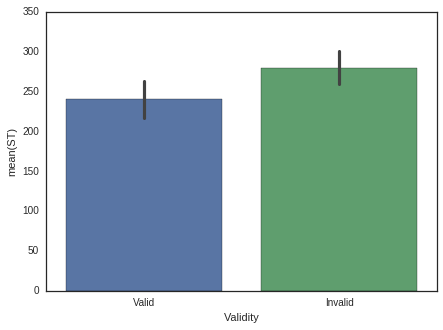

In [83]:
# # # # # # # stats on saccade onset latency # # # # # # #
plt.rcParams['figure.figsize']=(7,5)
sns.barplot(x = plotting.Validity, y = plotting.ST, ci = 68)

test = stats.ttest_rel(meanvaltime, meaninvtime)
print test.statistic, test.pvalue

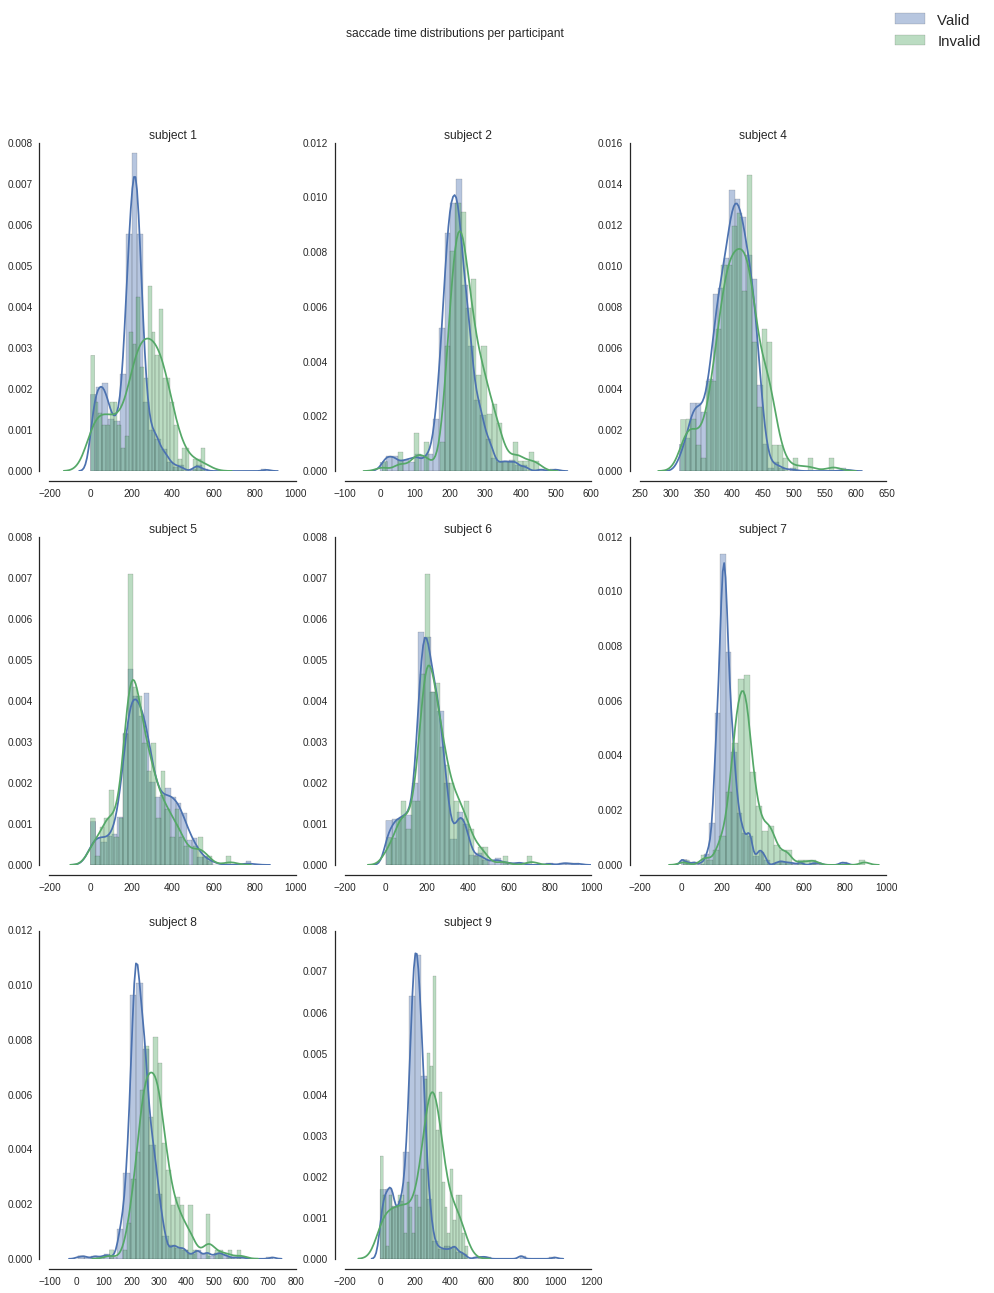

In [81]:
subs = [0,1,2,3,4,5,6,7]
plt.rcParams['figure.figsize']=(15,20) # 3:2 ratio needed cos 3 columns 2 rows
subject_histplots = plt.figure()
subject_histplots.suptitle('saccade time distributions per participant')
sns.set(style = 'white')
for i in subs:
#    if sublist[i] == 4:
#        ax1 = subject_histplots.add_subplot(3,3,i+1, title = 'subject %s'%(sublist[i]))
#        sns.distplot(np.divide(valids[i],4),   bins = 30, ax = ax1, label = 'Valid')
#        sns.distplot(np.divide(invalids[i],4), bins = 30, ax = ax1, label = 'Invalid') # yellow histogram for invalids
#    else:
    ax1 = subject_histplots.add_subplot(3,3,i+1, title = 'subject %s'%(sublist[i]))
    sns.distplot(valids[i],  bins = 30, ax = ax1, label = 'Valid')
    sns.distplot(invalids[i],bins = 30, ax = ax1, label = 'Invalid') # yellow histogram for invalids
sns.despine(offset = 10, trim = True) # removes the right and top axes from plot

handles, labels = ax1.get_legend_handles_labels()
subject_histplots.legend(handles, labels, prop = {'size':15})



#ax1 = fig.add_subplot(2,3,1)
#sns.distplot(valids[0], bins = 30, ax = ax1)

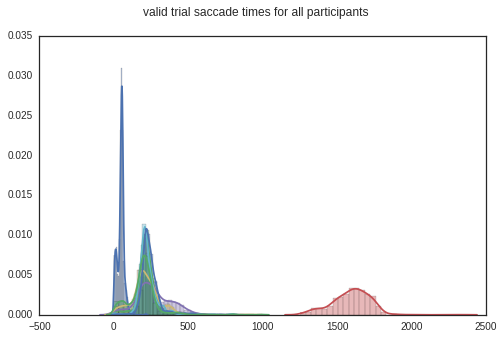

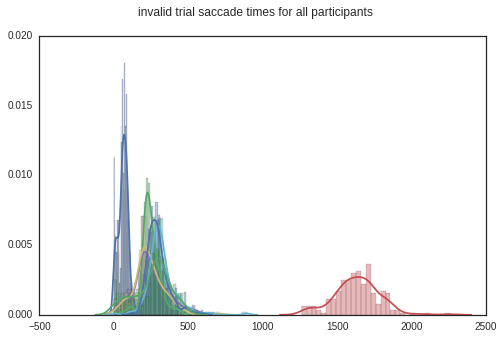

In [59]:
# valids and invalids contains, for each subject
#an array of the valid and invalid single trial saccade times (non-NaN)
plt.rcParams['figure.figsize']=(8,5)
validplot = plt.figure()
for i in range(len(valids)):
    sns.distplot(valids[i], bins = 30)
validplot.suptitle('valid trial saccade times for all participants')
invalidplot = plt.figure()
for i in range(len(invalids)):
    sns.distplot(invalids[i], bins = 30)
invalidplot.suptitle('invalid trial saccade times for all participants')


In [ ]:
         tstart     tend    dur    startx  starty  startp endx     endy    endp
EFIX L   4980679	4980757	79	  116.0	 -418.0	   6143	  985.8	  408.1	   6143

#                 left    right   pupil    left   right  pupil
start 4980679	  988.1	  410.9	 6124.0	  993.4	  459.3	 6302.0
end   4980757	  987.8	  412.1	 6167.0	  998.5	  450.1	 6343.0


In [ ]:
# playing around: how to check the accuracy of a saccade
#
# two ways of doing this:
# 1 - euclidian distance of the saccade destination from the target location
# 2 - angle of saccade destination from fixation, and angle of target
#     angular difference between two is a parametric measure of accuracy.
#     polar angles let you look at over-/under- shoots, and angular error

In [61]:
edat[0][0]['behaviour']

['triggers', 'behaviour', 'trackertime', 'time', 'y', 'x', 'events', 'size']

In [41]:
tempsub = edat[3]
sacctrls = [x for x in range(len(tempsub)) if tempsub[x]['behaviour']['task'] == 2.0 and tempsub[x]['behaviour']['validity'] == 1.0]
temptrl = tempsub[1]
print temptrl['events']['Esac'][0], '\n'
print temptrl['events']['Esac'][0][0], '\n' #start of saccade
print temptrl['events']['Esac'][0][1], '\n' #end of saccade
#find timestamp for the sample of where the saccade beings
print np.squeeze(np.where(temptrl['trackertime'] == temptrl['events']['Esac'][0][0])), '\n'
startsamp = np.squeeze(np.where(temptrl['trackertime'] == temptrl['events']['Esac'][0][0]))
endsamp = np.squeeze(np.where(temptrl['trackertime'] == temptrl['events']['Esac'][0][1]))
print temptrl['x'][startsamp], temptrl['y'][startsamp], '\n' # x&y of start of saccade, in gaze
print temptrl['x'][endsamp], temptrl['y'][endsamp]           # x&y of end of saccade, in gaze
print temptrl['behaviour']['targlocpix']



[5618538, 5618587, 50, 63.0, 685.0, 1813.0, 1470.0] 

5618538 

5618587 

1951 

948.7 576.2 

1351.6 720.9
[1359  705]


In [84]:
temptrl['events']['Esac'][eventnumber][0] - starting point of event
temptrl['events']['Esac'][eventnumber][1] -   ending point of event
temptrl['events']['Esac'][eventnumber][2] -       duration of event

[[19029018, 19029037, 20, 981.6, 535.5, 975.5, 570.6],
 [19029018, 19029037, 20, 938.9, 537.8, 933.5, 560.6],
 [19030940, 19030994, 55, 937.8, 572.8, 589.2, 696.6],
 [19030940, 19030999, 60, 984.5, 581.2, 604.3, 712.3],
 [19031179, 19031228, 50, 597.9, 738.6, 946.7, 623.4],
 [19031178, 19031229, 52, 562.0, 711.2, 893.8, 607.8],
 [19031370, 19031388, 19, 910.4, 606.6, 919.3, 552.4],
 [19031369, 19031391, 23, 970.9, 624.7, 977.4, 573.5]]

In [82]:
tempsub = edat[2]
sacctrls = [x for x in range(len(tempsub)) if tempsub[x]['behaviour']['task'] == 2.0 and tempsub[x]['behaviour']['validity'] == 1.0]
temptrl = tempsub[sacctrls[0]]
print temptrl['behaviour']['firstsaccade'], '\n'
#print temptrl['behaviour']['targlocpix'], '\n'

startsamp = temptrl['behaviour']['firstsaccade'][0]
endsamp   = temptrl['behaviour']['firstsaccade'][1]

startind = np.squeeze(np.where(temptrl['trackertime'] == startsamp))
endind   = np.squeeze(np.where(temptrl['trackertime'] == endsamp))

print startind,endind, (endind-startind), '\n'
print temptrl['x'][startind], temptrl['y'][startind], '\n'
print temptrl['trackertime'][startind]



print '\n', '\n'



[ 19030940.   19030994.         55.        937.8       572.8       589.2
       696.6] 

2165 2219 54 

984.5 581.2 

19030940





[[19029018, 19029037, 20, 981.6, 535.5, 975.5, 570.6], [19029018, 19029037, 20, 938.9, 537.8, 933.5, 560.6], [19030940, 19030994, 55, 937.8, 572.8, 589.2, 696.6], [19030940, 19030999, 60, 984.5, 581.2, 604.3, 712.3], [19031179, 19031228, 50, 597.9, 738.6, 946.7, 623.4], [19031178, 19031229, 52, 562.0, 711.2, 893.8, 607.8], [19031370, 19031388, 19, 910.4, 606.6, 919.3, 552.4], [19031369, 19031391, 23, 970.9, 624.7, 977.4, 573.5]] 

[ 19030940.   19030994.         55.        937.8       572.8       589.2
       696.6] 

[672 659] 

[19030765, 1990]



[19029018, 19029037, 20, 981.6, 535.5, 975.5, 570.6] 

19029018 

19029037 

243 

981.6 535.5 

975.5 570.6
[ 981.6  981.3  980.8  979.8  978.   976.3  975.2  975.3  975.4  975.2
  975.   974.6  974.7  975.1  976.6  977.6  978.3  977.9  977.   975.5] 

[ 535.5  538.9  543.8  548.3  551.7  554.1  557.8  559.8  563.   564.9
  569.9  574.2  578.6  580.7  581.4  579.8  576.7  573.2  572.1  570.6]


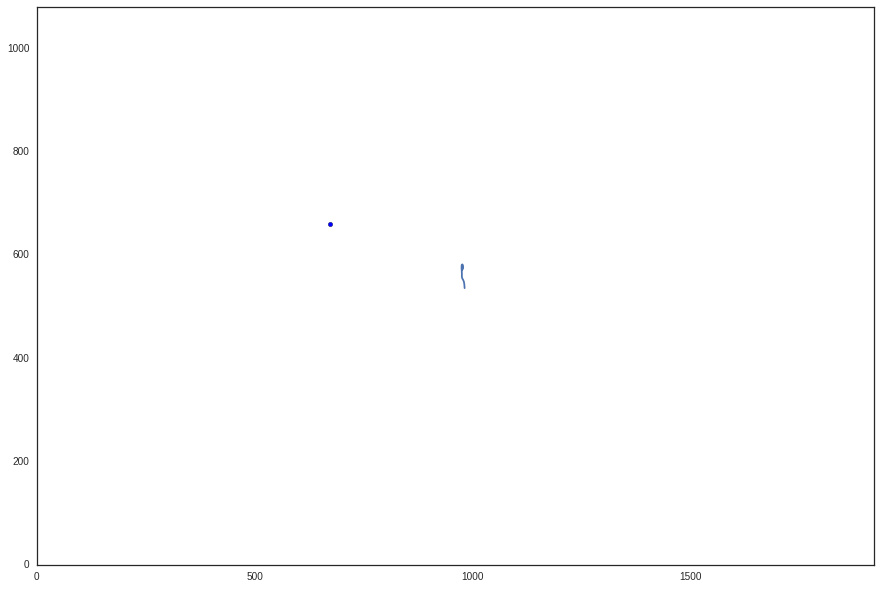

In [73]:
print temptrl['events']['Esac'][0], '\n'
print temptrl['events']['Esac'][0][0], '\n' #start of saccade
print temptrl['events']['Esac'][0][1], '\n' #end of saccade
#find timestamp for the sample of where the saccade beings
print np.squeeze(np.where(temptrl['trackertime'] == temptrl['events']['Esac'][0][0])), '\n'
startsamp = np.squeeze(np.where(temptrl['trackertime'] == temptrl['events']['Esac'][0][0]))
endsamp   = np.squeeze(np.where(temptrl['trackertime'] == temptrl['events']['Esac'][0][1]))
print temptrl['x'][startsamp], temptrl['y'][startsamp], '\n' # x&y of start of saccade, in gaze
print temptrl['x'][endsamp], temptrl['y'][endsamp]           # x&y of end of saccade, in gaze

plt.rcParams['figure.figsize']=(15,10)
plt.plot(temptrl['x'][243:263], temptrl['y'][243:263]);
axes = plt.gca()
axes.set_xlim([0,1920])
axes.set_ylim([0,1080])

plt.scatter(672,659)
print temptrl['x'][243:263], '\n'
print temptrl['y'][243:263]

In [48]:
# saccades: start, end, duration, startx, starty, endx, endy
# saccade task, target location is loc 7
print edat[1][1]['behaviour']['targloc']
print edat[1][1]['behaviour']['targlocpix'], '\n'
print edat[1][1]['behaviour']['firstsaccade']
print eptarglocations[7 -1]
#plt.plot(targlocations[:,0], targlocations[:,1])

7.0
[1079  252] 

[ 4423206.   4423251.        46.       988.7      594.3     1130.
      287.8]
[1079  252]


In [38]:
trial = 7
# saccade task, target location is loc 7
print edat[3][trial]['behaviour']['targlocpix'], '\n'
print edat[3][trial]['behaviour']['firstsaccade'], '\n'
print obtarglocations[7-1]

#plt.plot(targlocations[:,0], targlocations[:,1])
#plt.plot(edat[3][trial]['behaviour']['targlocpix'][0], edat[3][trial]['behaviour']['targlocpix'][1])

[1125  141] 

[ 5642639.  5642680.       42.      109.      310.      632.    -1663.] 

[1125  141]


In [45]:
#plt.plot(edat[3][7]['x'])
#plt.plot(edat[3][7]['y'])
print edat[3][7]['events']['Esac']

[[5642639, 5642680, 42, 109.0, 310.0, 632.0, -1663.0], [5642640, 5642682, 43, 40.0, 528.0, 674.0, -1572.0], [5642836, 5642885, 50, 738.0, -1726.0, 133.0, 157.0], [5642838, 5642885, 48, 736.0, -1578.0, 107.0, 427.0], [5643085, 5643096, 12, 103.0, 399.0, 12.0, 523.0], [5643086, 5643097, 12, 148.0, 201.0, 70.0, 334.0]]


In [36]:
#get precision of a saccade (euclidian distance of saccade end point from a coordinate (of centre of target))
#check if within certain error range (100 pix appropriate?)

#these target locations aren't right, waiting on nick for them
#need to correct coordinates to transform from eyetracker space to normal cartesian space

#EP locations
eptarglocations = np.array([[288,119], # cueloc = 1
                           [119, 288], # cueloc = 2
                           [-119, 288],# cueloc = 3
                           [-288, 119],# cueloc = 4
                           [-288,-119],# cueloc = 5
                           [-119,-288],# cueloc = 6
                           [119,-288], # cueloc = 7
                           [288,-119]] # cueloc = 8
                           )

#ohba locations
obtarglocations = np.array([[399,165],  # cueloc = 1
                           [165, 399], # cueloc = 2
                           [-165, 399],# cueloc = 3
                           [-399, 165],# cueloc = 4
                           [-399,-165],# cueloc = 5
                           [-165,-399],# cueloc = 6
                           [165,-399], # cueloc = 7
                           [399,-165]] # cueloc = 8
                           )
eptarglocations[:,0] = eptarglocations[:,0]+(resxy[0]/2) # correct x from tracker coords to normal coords
eptarglocations[:,1] = eptarglocations[:,1]+(resxy[1]/2) # correct y from tracker coords to normal coords

obtarglocations[:,0] = obtarglocations[:,0]+(resxy[0]/2) # correct x from tracker coords to normal coords
obtarglocations[:,1] = obtarglocations[:,1]+(resxy[1]/2) # correct y from tracker coords to normal coords


#temp = edat[1] #read in subject 5, 1khz sample rate eyetracking
#saccvals = [x for x in range(len(temp)) if temp[x]['behaviour']['task']==2.0 and temp[x]['behaviour']['validity']==1.0]
#loc1 = [y for y in saccvals if temp[y]['behaviour']['cueloc'] == 1.0]
#print loc1, '\n'

#print targlocations[0], '\n'
#print temp[0]['behaviour']['firstsaccade'], '\n'
#print temp[0]['events']['Efix']


In [ ]:
trial = temp[itrl]
print trial.keys()
print trial['behaviour'].keys(), '\n'
print trial['behaviour']['firstsaccade'] # start, end, duration, startx, starty, endx (5), endy(6)
target = cuelocations[int(trial['behaviour']['targloc'])]
print target

dist = np.sqrt((trial['behaviour']['firstsaccade'][5]-target[0])**2 + (trial['behaviour']['firstsaccade'][6]-target[1])**2)
print dist

In [ ]:
cuelocations= np.array([[288,199],[119, 288],[-119, 288],[-288, 119],[-288,-119],[-119,-288],[119,-288],[288,-119]])
cuelocations[:,0] = cuelocations[:,0]+(resxy[0]/2)
cuelocations[:,1] = cuelocations[:,1]+(resxy[1]/2)

print cuelocations
plt.figure(figsize = (10,10))
plt.scatter(cuelocations[1,0],cuelocations[1,1])
plt.scatter(960,540)

In [ ]:
print trial['behaviour']['cueloc']
print trial['behaviour']['targloc'], trial['x'][0]
plt.plot(trial['x'], trial['y'])

In [ ]:
trls = []
sacctask = [x for x in range(len(subject)) if subject[x]['behaviour']['task']==2.0]
for i in sacctask:
    trls.append(subject[i]['behaviour']['saccadetime'])
#sactimes = subject[]['behaviour']['saccadetime']

In [ ]:
# edat contains all, both eyetracking and behavioural, but it's computationally 'intensive' to create this
# every time you want to access this data. This structure should be created once only, then output as a
# text file that can be read in, rather than recreating and overwriting certain things each time
# this section will separate edat by subject - edat[0] contains subject 4 data at the moment and then write

# need to find a dataformat that can make each subject data to a file
#that can be read in the subsequent cell replacing the need for some cells above